<a href="https://colab.research.google.com/github/jungihong10/LSTM_pineapples/blob/main/lstm_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data is already preprocessed

*   removed unused Co2 (avg, max, min) columns
*   check for empty values
*   check for odd values (too big/too small)



In [3]:
healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'


split the datafram into chunks of 200 rows each and then export each group of 200 rows as a single csv.

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import random


def create_sequences_from_list(data_list, seq_length):
    sequences = []
    labels = []

    for data in data_list:
        unscaled_labels = data[:, -1]  # Store the original labels before scaling
        #scaled_data = scaler.fit_transform(data)
        #sequences.append(scaled_data[:seq_length, :-1])
        sequences.append(data[:seq_length, :-1])

        labels.append(unscaled_labels[0])  # Use the original unscaled label

    return np.array(sequences), np.array(labels)


# Modify the read_csv_files function to read and return both the file name and data
def read_csv_files(folder_path, label, max_samples=None):
    data_list = []
    file_list = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        if len(df) >= 200:  # Filter out files with less than 200 readings
            df["label"] = label
            data_list.append(df.values[:200, :])  # Truncate to 200 rows and convert DataFrame to NumPy array
            file_list.append(file)
    
    if max_samples is not None and len(data_list) > max_samples:
        data_list, file_list = zip(*random.sample(list(zip(data_list, file_list)), max_samples))

    return list(data_list), list(file_list)



healthy_folder = '/content/drive/MyDrive/n_dataprepro/'
diseased_folder = '/content/drive/MyDrive/d_dataprepro/'



# Read and label the CSV files
diseased_data_list, diseased_file_list = read_csv_files(diseased_folder, 1)
num_diseased_samples = len(diseased_data_list)
healthy_data_list, healthy_file_list = read_csv_files(healthy_folder, 0, max_samples=num_diseased_samples)

all_data_list = healthy_data_list + diseased_data_list
all_file_list = healthy_file_list + diseased_file_list

# Split the data into train and test sets based on the file list
train_file_list, test_file_list, train_data_list, test_data_list = train_test_split(
    all_file_list, all_data_list, test_size=0.2, random_state=42
)

# Shuffle the train and test data lists
random.shuffle(train_data_list)
random.shuffle(test_data_list)

# Create sequences
seq_length = 200

X_train, y_train = create_sequences_from_list(train_data_list, seq_length)
X_test, y_test = create_sequences_from_list(test_data_list, seq_length)


In [6]:

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/10
184/184 [==============================] - 14s 22ms/step - loss: 0.1682 - accuracy: 0.9501 - val_loss: 0.0918 - val_accuracy: 0.9523
Epoch 2/10
184/184 [==============================] - 4s 20ms/step - loss: 0.0979 - accuracy: 0.9671 - val_loss: 0.0135 - val_accuracy: 0.9980
Epoch 3/10
184/184 [==============================] - 3s 17ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/10
184/184 [==============================] - 3s 15ms/step - loss: 0.1135 - accuracy: 0.9693 - val_loss: 0.0103 - val_accuracy: 0.9980
Epoch 5/10
184/184 [==============================] - 3s 15ms/step - loss: 0.0235 - accuracy: 0.9952 - val_loss: 0.0157 - val_accuracy: 0.9980
Epoch 6/10
184/184 [==============================] - 3s 15ms/step - loss: 0.0147 - accuracy: 0.9973 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/10
184/184 [==============================] - 4s 21ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 5.8186e-04 - val_accuracy: 1

In [7]:
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


X shape: (7336, 200, 9)
y shape: (7336,)


In [8]:
print("X_train shape:", X_train)


X_train shape: [[[16.3 16.9 15.3 ... 14.2 16.1 11.2]
  [16.3 16.7 15.9 ... 14.7 16.1 13.3]
  [16.2 16.3 16.1 ... 15.  15.2 14.7]
  ...
  [14.6 15.1 13.5 ... 13.1 13.4 12.8]
  [14.2 15.1 13.6 ... 13.  13.2 12.8]
  [14.3 15.2 13.7 ... 12.9 13.1 12.8]]

 [[29.8 29.9 29.6 ... 16.8 17.1 16.4]
  [29.4 29.8 29.1 ... 15.6 15.9 15.2]
  [29.4 29.8 29.1 ... 15.7 17.1 14.8]
  ...
  [26.4 26.6 26.3 ... 15.7 16.6 14.8]
  [26.7 27.1 26.3 ... 15.5 16.  14.8]
  [26.8 27.  26.6 ... 15.6 16.  15.1]]

 [[24.  24.8 23.6 ... 16.8 18.7 15.3]
  [24.3 24.7 23.9 ... 16.3 18.9 15. ]
  [24.3 24.6 23.6 ... 19.1 20.4 18.2]
  ...
  [12.6 20.   9.  ...  9.6 14.6  6.9]
  [12.3 20.3  8.9 ...  9.8 14.8  7.5]
  [14.9 20.4  8.7 ... 11.5 14.8  7.6]]

 ...

 [[23.6 27.7 22.1 ... 12.5 22.7  8.9]
  [25.9 27.6 21.8 ... 19.4 22.5 10.5]
  [24.7 27.4 21.2 ... 16.8 21.8  9.6]
  ...
  [13.  13.2 12.9 ... 12.2 12.2 12.1]
  [15.1 19.4 12.3 ... 12.7 14.1  9.6]
  [13.9 14.3 13.6 ... 12.9 13.1 12.9]]

 [[24.5 24.9 23.8 ... 17.2 20.4 15.

In [9]:
print("y_train shape:", y_train)


y_train shape: [0. 1. 0. ... 0. 0. 1.]


In [10]:
print("X_test shape:", X_test)


X_test shape: [[[20.9 21.4 20.4 ... 19.4 20.  18. ]
  [20.4 20.6 20.2 ... 18.  18.6 17.6]
  [21.  21.6 20.7 ... 16.6 17.6 15.8]
  ...
  [16.5 16.5 16.5 ... 16.2 16.2 16.1]
  [16.7 16.8 16.6 ... 16.2 16.2 16.1]
  [16.8 16.8 16.6 ... 16.4 16.4 16.2]]

 [[22.  22.1 21.9 ... 14.8 15.2 14.4]
  [21.9 22.1 21.6 ... 13.9 14.2 13.4]
  [21.4 21.7 21.1 ... 12.3 13.4 11.4]
  ...
  [ 9.2  9.3  9.1 ...  8.6  8.6  8.6]
  [ 9.   9.1  8.9 ...  8.5  8.6  8.4]
  [ 8.9  9.   8.9 ...  8.6  8.6  8.6]]

 [[23.6 27.7 22.1 ... 12.5 22.7  8.9]
  [25.9 27.6 21.8 ... 19.4 22.5 10.5]
  [24.7 27.4 21.2 ... 16.8 21.8  9.6]
  ...
  [13.  13.2 12.9 ... 12.2 12.2 12.1]
  [15.1 19.4 12.3 ... 12.7 14.1  9.6]
  [13.9 14.3 13.6 ... 12.9 13.1 12.9]]

 ...

 [[23.6 27.7 22.1 ... 12.5 22.7  8.9]
  [25.9 27.6 21.8 ... 19.4 22.5 10.5]
  [24.7 27.4 21.2 ... 16.8 21.8  9.6]
  ...
  [13.  13.2 12.9 ... 12.2 12.2 12.1]
  [15.1 19.4 12.3 ... 12.7 14.1  9.6]
  [13.9 14.3 13.6 ... 12.9 13.1 12.9]]

 [[25.5 26.4 21.9 ... 16.9 17.9 14.2

In [11]:
print("y_test shape:", y_test)


y_test shape: [0. 1. 0. ... 0. 0. 1.]


58/58 [==============================] - 1s 8ms/step


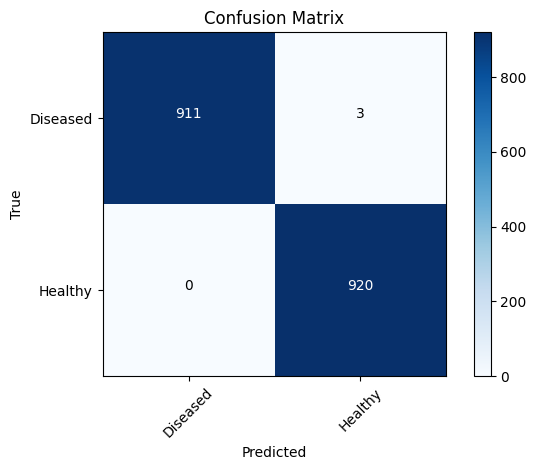

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ['Diseased', 'Healthy']

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > (cm.max() / 2) else "black")
plt.show()


In [13]:
from sklearn.metrics import precision_recall_fscore_support

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate precision, recall, F1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

# Print the results
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)
print('Support:', support)


58/58 [==============================] - 0s 8ms/step
Precision: [1.         0.99674973]
Recall: [0.99671772 1.        ]
F1-score: [0.99835616 0.99837222]
Support: [914 920]


Testing the model out using separate test cases.

In [14]:
def preprocess_single_file(file_path, seq_length):
    df = pd.read_csv(file_path)
    df["label"] = 0  # Add a dummy label column
    data = df.values[:seq_length, :]  # Truncate to seq_length rows if needed
    #scaled_data = scaler.transform(data)
    #X = np.array([scaled_data[:, :-1]])  # Create a 3D array with just one sample
    X = np.array([data[:, :-1]])  # Create a 3D array with just one sample

    return X

def status(x):
    if x > 0.5:
        print("Unhealthy")
    else:
        print("Healthy")
# Example usage:

sample_file_path = "/content/drive/MyDrive/d_data_test/preprocessed_d_605916.csv"
seq_length = 200

X_sample = preprocess_single_file(sample_file_path, seq_length)

# Predict on the sample file
y_sample_pred = model.predict(X_sample)
print(y_sample_pred[0])

# Print the result
status(y_sample_pred[0])





1/1 [==============================] - 0s 32ms/step
[0.9983211]
Unhealthy


In [15]:
# Example usage:

sample_file_path = "/content/drive/MyDrive/n_data_test/preprocessed_n_851866.csv"
seq_length = 200

X_sample = preprocess_single_file(sample_file_path, seq_length)

# Predict on the sample file
y_sample_pred = model.predict(X_sample)

# Print the result
print(y_sample_pred[0])

status(y_sample_pred[0])




1/1 [==============================] - 0s 22ms/step
[0.00046575]
Healthy


In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 50)           12000     
                                                                 
 dropout (Dropout)           (None, 200, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Check class distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Class distribution in training set:", dict(zip(unique_train, counts_train)))
print("Class distribution in test set:", dict(zip(unique_test, counts_test)))


Class distribution in training set: {0.0: 3671, 1.0: 3665}
Class distribution in test set: {0.0: 914, 1.0: 920}


Considering the class distribution and the evaluation metrics, it seems that the model is performing well. There is no significant class imbalance in the dataset, and the precision, recall, and F1-score are all high.

In [18]:
from sklearn.metrics import classification_report

# Predict the test labels
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate and print the classification report
report = classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Diseased'])
print(report)


58/58 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       914
    Diseased       1.00      1.00      1.00       920

    accuracy                           1.00      1834
   macro avg       1.00      1.00      1.00      1834
weighted avg       1.00      1.00      1.00      1834



In [19]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

def train_and_evaluate_model(X_train, y_train, X_val, y_val):
    # Create and compile a new instance of the model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    return accuracy

# Combine the train and test sets for cross-validation
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Define the number of folds for cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Run cross-validation
cv_accuracies = []
for train_index, val_index in kfold.split(X, y):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    fold_accuracy = train_and_evaluate_model(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
    cv_accuracies.append(fold_accuracy)

# Calculate and print the average accuracy across all folds
avg_accuracy = np.mean(cv_accuracies)
print(f"Average accuracy across {num_folds}-fold cross-validation: {avg_accuracy}")


Average accuracy across 5-fold cross-validation: 0.9202835321426391


With the updated class distribution, the model's performance appears more reasonable. The class distribution in both the training and test sets is now nearly balanced, which is an improvement compared to the original data.

The test set's precision, recall, and f1-score for both classes are still very close to 1.00, indicating that the model performs well on both classes. However, the 5-fold cross-validation accuracy is lower at 92.03%, which is more consistent with real-world expectations for a classification task like this. The cross-validation result provides a better estimate of the model's performance on unseen data, as it accounts for variability in the dataset by training and evaluating the model on different subsets of the data.

In summary, the use of undersampling and cross-validation has led to a more balanced class distribution and a more robust evaluation of the model's performance. While the test set's accuracy is still very high, the cross-validation accuracy provides a more realistic estimate of the model's generalization performance.